## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [22]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [23]:
train, test = keras.datasets.cifar10.load_data()

In [24]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [27]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [28]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], regulizer=l1 , ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=regulizer(ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=regulizer(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [29]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
REGULARIZERS= [l1, l1_l2]

In [30]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio, regulizer in itertools.product(L2_EXP, REGULARIZERS):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %s , Ratio = %.6f, " % (str(regulizer), regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], regulizer=regulizer, ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "Regulizer-%s-exp-l2-%s" % (str(regulizer), str(regulizer_ratio))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = <function l1 at 0x7f5f00fa58c8> , Ratio = 0.010000, 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
E

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 149us/step - loss: 197.8732 - acc: 0.2502 - val_loss: 36.0821 - val_acc: 0.2673
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 15.9921 - acc: 0.1104 - val_loss: 5.1727 - val_acc: 0.1000
Epoch 3/50
50000/50000 [==============================] - 7s 147us/step - loss: 3.2267 - acc: 0.1000 - val_loss: 2.4721 - val_acc: 0.1000
Epoch 4/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.4633 - acc: 0.0975 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 5/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.4625 - acc: 0.0988 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 2.4624 - acc: 0.0965 - val_loss: 2.4624 - val_acc: 0.1000
Epoch 7/50
50000/50000 [==============================] - 7s 148us/step - loss: 2.4624 - acc: 0.0975 - val_loss: 2.462

50000/50000 [==============================] - 7s 136us/step - loss: 6.0166 - acc: 0.2677 - val_loss: 5.8128 - val_acc: 0.3372
Epoch 2/50
50000/50000 [==============================] - 7s 133us/step - loss: 5.7247 - acc: 0.3600 - val_loss: 5.6393 - val_acc: 0.3857
Epoch 3/50
50000/50000 [==============================] - 7s 137us/step - loss: 5.5755 - acc: 0.3898 - val_loss: 5.5043 - val_acc: 0.4075
Epoch 4/50
50000/50000 [==============================] - 7s 132us/step - loss: 5.4524 - acc: 0.4146 - val_loss: 5.4026 - val_acc: 0.4138
Epoch 5/50
50000/50000 [==============================] - 7s 137us/step - loss: 5.3422 - acc: 0.4292 - val_loss: 5.2930 - val_acc: 0.4349
Epoch 6/50
50000/50000 [==============================] - 7s 135us/step - loss: 5.2413 - acc: 0.4425 - val_loss: 5.2014 - val_acc: 0.4415
Epoch 7/50
50000/50000 [==============================] - 7s 134us/step - loss: 5.1462 - acc: 0.4544 - val_loss: 5.1124 - val_acc: 0.4548
Epoch 8/50
50000/50000 [=====================

Epoch 2/50
50000/50000 [==============================] - 9s 184us/step - loss: 16.1578 - acc: 0.3610 - val_loss: 14.9855 - val_acc: 0.3723
Epoch 3/50
50000/50000 [==============================] - 9s 177us/step - loss: 13.9685 - acc: 0.3853 - val_loss: 12.9811 - val_acc: 0.3883
Epoch 4/50
50000/50000 [==============================] - 12s 244us/step - loss: 12.1191 - acc: 0.3995 - val_loss: 11.2882 - val_acc: 0.3959
Epoch 5/50
50000/50000 [==============================] - 9s 181us/step - loss: 10.5470 - acc: 0.4064 - val_loss: 9.8371 - val_acc: 0.4069
Epoch 6/50
50000/50000 [==============================] - 7s 147us/step - loss: 9.2088 - acc: 0.4143 - val_loss: 8.6027 - val_acc: 0.4098
Epoch 7/50
50000/50000 [==============================] - 8s 159us/step - loss: 8.0691 - acc: 0.4193 - val_loss: 7.5513 - val_acc: 0.4201
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 7.0980 - acc: 0.4239 - val_loss: 6.6584 - val_acc: 0.4252
Epoch 9/50
50000/50000 [==

Epoch 3/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.7121 - acc: 0.4004 - val_loss: 1.6835 - val_acc: 0.4066
Epoch 4/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6548 - acc: 0.4219 - val_loss: 1.6405 - val_acc: 0.4237
Epoch 5/50
50000/50000 [==============================] - 8s 160us/step - loss: 1.6074 - acc: 0.4376 - val_loss: 1.5995 - val_acc: 0.4346
Epoch 6/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.5697 - acc: 0.4508 - val_loss: 1.5667 - val_acc: 0.4457
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.5373 - acc: 0.4611 - val_loss: 1.5526 - val_acc: 0.4482
Epoch 8/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5080 - acc: 0.4721 - val_loss: 1.5195 - val_acc: 0.4628
Epoch 9/50
50000/50000 [==============================] - 15s 307us/step - loss: 1.4827 - acc: 0.4801 - val_loss: 1.5023 - val_acc: 0.4673
Epoch 10/50
50000/50000 [========

Epoch 4/50
50000/50000 [==============================] - 8s 156us/step - loss: 9.9241 - acc: 0.4025 - val_loss: 9.2877 - val_acc: 0.4070
Epoch 5/50
50000/50000 [==============================] - 8s 156us/step - loss: 8.7243 - acc: 0.4103 - val_loss: 8.1847 - val_acc: 0.4171
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 7.7032 - acc: 0.4168 - val_loss: 7.2446 - val_acc: 0.4145
Epoch 7/50
50000/50000 [==============================] - 8s 151us/step - loss: 6.8319 - acc: 0.4256 - val_loss: 6.4424 - val_acc: 0.4273
Epoch 8/50
50000/50000 [==============================] - 8s 154us/step - loss: 6.0886 - acc: 0.4314 - val_loss: 5.7544 - val_acc: 0.4330
Epoch 9/50
50000/50000 [==============================] - 8s 152us/step - loss: 5.4527 - acc: 0.4342 - val_loss: 5.1671 - val_acc: 0.4367
Epoch 10/50
50000/50000 [==============================] - 8s 151us/step - loss: 4.9103 - acc: 0.4391 - val_loss: 4.6733 - val_acc: 0.4369
Epoch 11/50
50000/50000 [========

Epoch 5/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6286 - acc: 0.4262 - val_loss: 1.6086 - val_acc: 0.4299
Epoch 6/50
50000/50000 [==============================] - 8s 151us/step - loss: 1.5867 - acc: 0.4429 - val_loss: 1.5849 - val_acc: 0.4438
Epoch 7/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.5513 - acc: 0.4542 - val_loss: 1.5524 - val_acc: 0.4502
Epoch 8/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.5219 - acc: 0.4661 - val_loss: 1.5314 - val_acc: 0.4543
Epoch 9/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.4932 - acc: 0.4738 - val_loss: 1.5075 - val_acc: 0.4699
Epoch 10/50
50000/50000 [==============================] - 9s 171us/step - loss: 1.4695 - acc: 0.4835 - val_loss: 1.4918 - val_acc: 0.4703
Epoch 11/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.4446 - acc: 0.4933 - val_loss: 1.4680 - val_acc: 0.4775
Epoch 12/50
50000/50000 [=======

Epoch 6/50
50000/50000 [==============================] - 8s 169us/step - loss: 7.7107 - acc: 0.4145 - val_loss: 7.2508 - val_acc: 0.4167
Epoch 7/50
50000/50000 [==============================] - 8s 167us/step - loss: 6.8398 - acc: 0.4204 - val_loss: 6.4507 - val_acc: 0.4223
Epoch 8/50
50000/50000 [==============================] - 8s 166us/step - loss: 6.0951 - acc: 0.4260 - val_loss: 5.7634 - val_acc: 0.4266
Epoch 9/50
50000/50000 [==============================] - 8s 155us/step - loss: 5.4598 - acc: 0.4301 - val_loss: 5.1769 - val_acc: 0.4312
Epoch 10/50
50000/50000 [==============================] - 9s 178us/step - loss: 4.9166 - acc: 0.4351 - val_loss: 4.6778 - val_acc: 0.4371
Epoch 11/50
50000/50000 [==============================] - 10s 199us/step - loss: 4.4521 - acc: 0.4398 - val_loss: 4.2432 - val_acc: 0.4420
Epoch 12/50
50000/50000 [==============================] - 11s 210us/step - loss: 4.0550 - acc: 0.4438 - val_loss: 3.8967 - val_acc: 0.4299
Epoch 13/50
50000/50000 [====

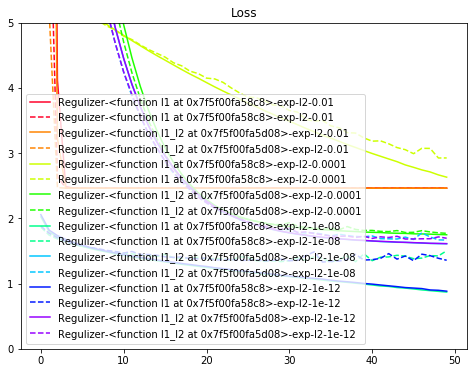

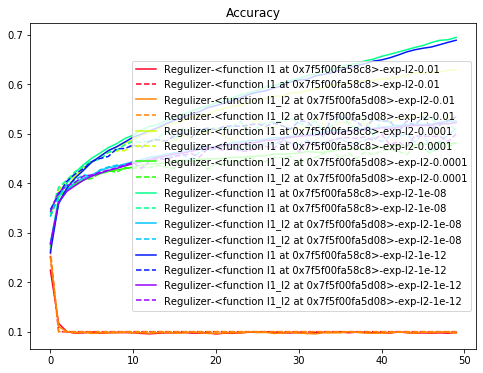

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()